<a href="https://colab.research.google.com/github/JohanFendi/Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt


url = "https://homl.info/titanic.tgz"
path = "datasets/titanic.tgz"
dir_name = "datasets"

def load_data(url, path, dir_name):
  file_path = Path(path)
  if not file_path.is_file():
    Path(dir_name).mkdir(exist_ok=True,parents=True)
    respons = urllib.request.urlretrieve(url, file_path)
    with tarfile.open(file_path) as data_tarball:
      data_tarball.extractall(path=dir_name)


def get_titanic_data():
  return pd.read_csv(Path("datasets/titanic/test.csv")), pd.read_csv(Path("datasets/titanic/train.csv"))

load_data(url, path, dir_name)
test, train = get_titanic_data()



In [8]:
print(train.info())
print(train.head())
print(train["Embarked"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                      

(array([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   6.,
         60., 100., 108.,  21.,  18.,   6.,  30.,   6.,  12.,  48.,  24.,
         18.,  19.,   3.,  10.,  12.,  15.,   9.,  14.,  49.,  33.,  12.,
         29.,   7.,  10.,   5.,  14.,   4.,   6.,   4.,  20.,  12.,   7.,
          4.,   4.,  12.,  12.,  19.,   8.,  10.,   0.,   2.,   9.,   4.,
          0.,   7.,   0.,   9.,   2.,   0.,   0.,   0.,   4.,   1.,   4.,
          2.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.]),
 array([0.        , 0.06240917, 0.12481835, 0.18722752, 0.24963669,
        0.31204587, 0.37445504, 0.43686421, 0.49927339, 0.56168256,
        0.62409174, 0.68650091, 0.74891008, 0.81131926, 0.87372843,
        0.9361376 , 0.99854678, 1.06095595, 1.12336512, 1.1857743 ,
        1.24818347, 1.31059264, 1.37300182, 1.

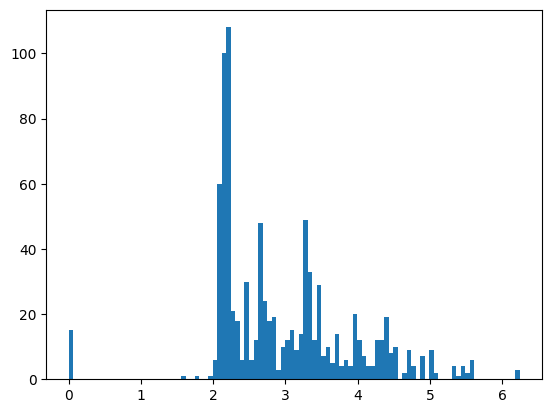

In [9]:
log_fare = np.log1p(train["Fare"])
plt.hist(log_fare, bins = 100)


(array([216.,   0.,   0.,   0.,   0., 184.,   0.,   0.,   0., 491.]), array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]), <BarContainer object of 10 artists>)


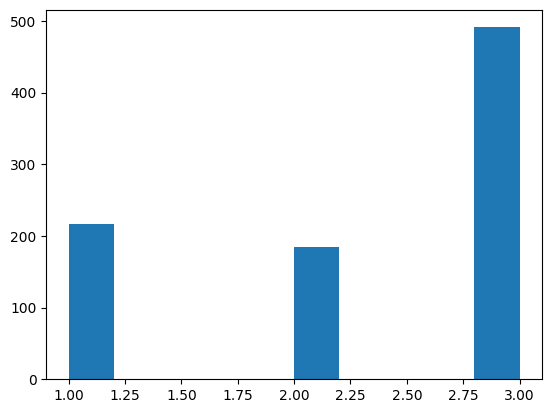

In [10]:
print(plt.hist(train["Pclass"]))

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def create_imputer(strat):
  return SimpleImputer(strategy=strat)

def create_OneHotEncoder(sparse):
  return OneHotEncoder(sparse_output=sparse)

def cat_encoder():
  return Pipeline(
      [
          ("imputer", create_imputer("most_frequent")),
          ("encoder", create_OneHotEncoder(False))
      ]
  )

log_transformer = FunctionTransformer(np.log1p)


preprocessing = ColumnTransformer(
    [
        ("num_imputer", create_imputer("mean"), ["Age"]),
        ("coder_Sex", cat_encoder(), ["Sex"]),
        ("coder_Embarked", cat_encoder(), ["Embarked"]),
        ("log_transformer", log_transformer, ["Fare"]),
        ("dropper", "drop", ["Name", "Ticket", "Cabin", "PassengerId"])

    ], remainder="passthrough"
)



In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier(n_estimators = 60, max_depth = 8, random_state=42)
svc_classifier = SVC()

def create_pipeline(clf, pre):
  return Pipeline(
    [
        ("pre", pre),
        ("clf", clf)
    ]
)

rf_pipeline = create_pipeline(rf_classifier, preprocessing)
dt_pipeline = create_pipeline(dt_classifier, preprocessing)
svc_pipeline = create_pipeline(svc_classifier, preprocessing)


In [32]:
embarked = train["Embarked"]
encoded = create_OneHotEncoder(False).fit_transform(embarked.to_frame())
print(encoded)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [33]:
train_y, train_x = train["Survived"], train.drop(columns=["Survived"])
dt_pipeline.fit(train_x, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_imputer',
                                                  SimpleImputer(), ['Age']),
                                                 ('coder_Sex',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Sex']),
                                                 ('coder_Embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Embarked']),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['Fare']),
                                                 ('dropper', 'drop',
                                                  ['Name', 'Ticket', 'Cabin',
                                                   'PassengerId'])])),
                ('clf', DecisionTreeClassifier())])

In [34]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix


predictions = dt_pipeline.predict(train_x)
precision = precision_score(train_y, predictions)
recall = recall_score(train_y, predictions)
print(precision, recall) #Overfits


0.9939393939393939 0.9590643274853801


In [35]:
counts = train_y.value_counts()
print(counts)

Survived
0    549
1    342
Name: count, dtype: int64


In [36]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(rf_pipeline, train_x, y=train_y)
print(precision_score(train_y, y_pred), recall_score(train_y, y_pred))

y_pred = cross_val_predict(dt_pipeline, train_x, y=train_y)
print(precision_score(train_y, y_pred), recall_score(train_y, y_pred))

y_pred = cross_val_predict(svc_pipeline, train_x, y=train_y)
print(precision_score(train_y, y_pred), recall_score(train_y, y_pred))

0.8154362416107382 0.7105263157894737
0.7020648967551623 0.695906432748538
0.84251968503937 0.3128654970760234


In [43]:
from sklearn.model_selection import GridSearchCV

paramGrid = {"clf__n_estimators": [i for i in range(20, 61, 10)],
             "clf__max_depth":[i for i in range(6,11)],
             'clf__min_samples_split': [1,2,3,4,5]}

grid_search = GridSearchCV(rf_pipeline, paramGrid, cv=3)
grid_search.fit(train_x, train_y)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_imputer',
                                                                         SimpleImputer(),
                                                                         ['Age']),
                                                                        ('coder_Sex',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['Sex']),
                                                                        ('coder_Embarked',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strat...
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['Embarked']),
                                                                        ('log_transformer',
                                                                         FunctionTransformer(func=<ufunc 'log1p'>),
                                                                         ['Fare']),
                                                                        ('dropper',
                                                                         'drop',
                                                                         ['Name',
                                                                          'Ticket',
                                                                          'Cabin',
                                                                          'PassengerId'])])),
                                       ('clf',
                                        RandomForestClassifier(max_depth=8,
                                                               n_estimators=60,
                                                               random_state=42))]),
             param_grid={'clf__max_depth': [6, 7, 8, 9, 10],
                         'clf__min_samples_split': [1, 2, 3, 4, 5],
                         'clf__n_estimators': [20, 30, 40, 50, 60]})

In [52]:
print(grid_search.best_params_)
y_pred = cross_val_predict(grid_search.best_estimator_, train_x, y=train_y)
print(precision_score(train_y, y_pred), recall_score(train_y, y_pred))
print(grid_search.score(train_x, train_y))



{'clf__max_depth': 8, 'clf__min_samples_split': 3, 'clf__n_estimators': 50}
0.8093645484949833 0.7076023391812866
0.9001122334455668


In [73]:
import pandas as pd
test_x = test.drop(columns =["Name", "Ticket", "Cabin", "PassengerId"])
y_pred = grid_search.best_estimator_.predict(test_x)


result = pd.DataFrame({
    "PassengerId": test["PassengerId"],
     "Survived": y_pred
     })

result.to_csv("result.csv", index=False)
print(result.columns)
print(result.head())

Index(['PassengerId', 'Survived'], dtype='object')
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
